<a href="https://colab.research.google.com/github/Benjamin-morel/TensorFlow/blob/main/05_transfert_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


# **Machine Learning Model: image classification with transfert learning**

| | |
|------|------|
| Filename | 05_transfert_learning.ipynb |
| Author(s) | Benjamin Morel (benjaminmorel27@gmail.com) |
| Date | December 19, 2024 |
| Aim(s) | Classify images of flowers with a pre-trained network |
| Dataset(s) | Flower API Google database [[1]](https://www.kaggle.com/datasets/abdelrahmanatef01/flowers-dataset-for-image-classification)|
| Version | Python 3.10.12 - TensorFlow 2.17.1 |


<br> **!!Read before running!!** <br>
1. Fill in the inputs
2. GPU execution is recommanded if `training_phase = "Yes"`.
3. Run all and read comments.

---

#### **Motivation**

The flower Google API database is again used for this model, which uses a pre-trained model (MobileNet V2). The aim is to use this complex model to extract complex features from flower images. This is called transfer learning.

#### **Outline**
* retrieve data from a .csv
* cleaning data and pre-processing
* model definition and training
* comparison & predictions
* references




---


### **0. Input section**





The model has already been trained and the user can choose to used a pre-trained model (No) or to repeat the training phase (Yes). Using a pre-trained model saves time, computer resources and CO2 emissions.

In [1]:
training_phase = 'No'

In [2]:
# @title **1. Python librairies & display utilities [RUN ME]**

%pip install -q -U keras-tuner # install the tuner module

from numpy import array, argmax, max                         # scientific computing
from os import path, listdir                                 # miscellaneous operating system interfaces
from PIL import Image                                        # image processing capabilities
from tensorflow import keras, data, expand_dims, nn, concat  # machine learning models
from keras import layers, utils, Sequential, Input, losses
import matplotlib.pyplot as plt                              # graphing package
from pandas import DataFrame
import keras_tuner as kt                                     # optimal hyperparameter search tool

""" ############################################# """
""" Import Github files from TensorFlow repertory """
""" ############################################# """
def get_github_files():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata # go to the Github repertory TensorFlow and clone it
  training_curves_1 = Image.open("TensorFlow_duplicata/99_pre_trained_models/05_transfert_learning/training_curves_1.png") # see section 2.4
  training_curves_2 = Image.open("TensorFlow_duplicata/99_pre_trained_models/05_transfert_learning/training_curves_2.png") # see section 2.4
  model = keras.models.load_model('TensorFlow_duplicata/99_pre_trained_models/05_transfert_learning/05_transfert_learning.keras')
  model_fine_tune = keras.models.load_model('TensorFlow_duplicata/99_pre_trained_models/05_transfert_learning/05_transfert_learning_FT.keras')
  !rm -rf TensorFlow_duplicata/ # delete the cloned repertory
  return training_curves_1, training_curves_2, model, model_fine_tune

""" ############################################## """
""" Import Github photos from TensorFlow repertory """
""" ############################################## """
def get_github_photo():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata # go to the Github repertory TensorFlow and clone it
  tulip = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/tulip.jpeg") # see section 3
  rose = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/rose.jpeg") # see section 3
  daisy = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/daisy.jpeg") # see section 3
  sunflowers = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/sunflowers.jpeg") # see section 3
  bouquet = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/bouquet.jpeg") # see section 3
  bouquet_2 = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/bouquet_2.jpeg") # see section 3
  !rm -rf TensorFlow_duplicata/ # delete the cloned repertory
  return tulip, rose, daisy, sunflowers, bouquet, bouquet_2

""" ############################################## """
""" Import Github photos from TensorFlow repertory """
""" ############################################## """
def plot_images(image, *label):
  plt.imshow(image)
  plt.title("%s" %label)
  image = plt.axis("off")
  return image

""" ######################################################### """
""" plot training curves for the training and validation set  """
""" ######################################################### """
def plot_evolution(history):
  loss_train, loss_val = history[0], history[2]
  acc_train, acc_val = history[1], history[3]
  epochs = range(1, len(acc_train) + 1)

  fig = plt.subplot(2,1,1)
  plt.plot(epochs, loss_train, label='Training', color='blue')
  plt.plot(epochs, loss_val, label='Validation', color='orange')
  plt.legend(loc='best', fontsize=10)
  plt.grid(True, linestyle='--', alpha=0.6), plt.ylabel('Loss', fontsize=12)

  plt.subplot(2,1,2)
  plt.plot(epochs, acc_train, color='blue')
  plt.plot(epochs, acc_val, color='orange')
  plt.xlabel('Epochs', fontsize=12), plt.ylabel('Accuracy', fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.6)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


---


### **2. Retrieve data and data augmentation**

###### **2.1. Data acquisition**

The dataset is composed of 3,670 photos of flowers labelled in 5 classes: rose, dandelion, tulip, sunflower and daisy.

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = utils.get_file('flower_photos', dataset_url, untar=True)
data_dir = path.join(path.dirname(data_dir), 'flower_photos')

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


All images are shuffled and divided into 3 sets: training (80%), validation (16%) and test (4%).




In [4]:
batch_size = 32
img_height, img_width = 180, 180
AUTOTUNE = data.AUTOTUNE

train_dataset = utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", shuffle=True, seed=1, image_size=(img_height, img_width), batch_size=batch_size)
validation_dataset = utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation",shuffle=True, seed=1, image_size=(img_height, img_width), batch_size=batch_size)

class_names = train_dataset.class_names # flower names

val_ds_batch = data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_ds_batch // 5) # create a test set from 20% of the validation set
validation_dataset = validation_dataset.skip(val_ds_batch // 5)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [5]:
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

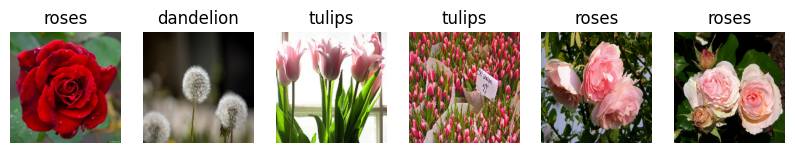

In [6]:
plt.figure(figsize=(10, 8))
for images, labels in train_dataset.take(1):
  tensor_images, tensor_labels = images, labels
  for i in range(6):
    ax = plt.subplot(1, 6, i + 1)
    plot_images(images[i].numpy().astype("uint8"), class_names[labels[i]])

###### **2.2. Data augmentation**

Random and realistic transformations are applied in order to increase the diversity of the training set.

In [7]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),], name="data_augmentation_layer") # 3 random transformations: horizontal flip, rotation & zoom

images_modified = data_augmentation(tensor_images) # apply to the example set

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


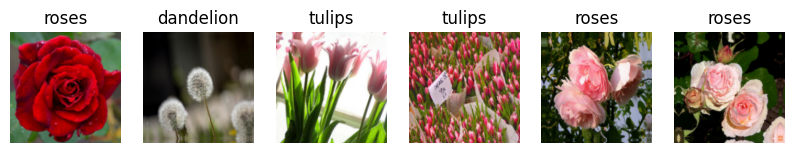

In [8]:
plt.figure(figsize=(10, 8))
for i in range(6):
  ax = plt.subplot(1, 6, i + 1)
  plot_images(images_modified[i].numpy().astype("uint8"), class_names[labels[i]])

---


### **3. Model creation**

###### **3.1. MobileNet V2 as an extractor model**

MobileNet V2 is one of the pre-trained models integrated into Keras. It has been trained on a subset of the ImagetNet, a labeled image database with 1000 classes.

Despite this large number of classes, there's no guarantee that MobileNet V2 has been trained with images of roses, daisies and other flowers during the training phase. Therefore, the MobileNet's classification model is removed and only the feature extraction model is kept. A custom classification model is attached to the output of Mobile Net V2 and trained from scratch.

To used MobileNet V2, inputs are pre-processed to conform to the input pixel value expected by MobileNet V2 [[2]](https://keras.io/api/applications/mobilenet/).

In [9]:
preprocess_layer = keras.applications.mobilenet_v2.preprocess_input # rescale: [0,255] --> [-1,1]

MobileNet V2 is imported from the `keras.applications` API with weights computed during the ImageNet training. Classification layers are removed (`include_top=False`). Input image size is specified.


In [10]:
img_size = (img_height, img_width)
img_shape = img_size + (3,) # add 3 input channels (=rgb code)
extractor_model = keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

<ipython-input-10-aaff06bff94b>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  extractor_model = keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


`extractor_model` is "frezze" in order to avoid updating its weights.

In [11]:
extractor_model.trainable = False

###### **3.2. Main model creation**

`extractor_model` is included in a larger model capable to pre-process inputs and classify them.

In [12]:
def create_model():
  inputs = keras.Input(shape=(img_height, img_width, 3))
  x = data_augmentation(inputs)                         # input pre-processing layer
  x = preprocess_layer(x)                               # input pre-processing layer
  x = extractor_model(x, training=False)                # MoibleNet V2 - output size = (5, 5, 1280)
  x = keras.layers.GlobalAveragePooling2D()(x)          # data flattening - output size = (, 1280)
  x = keras.layers.Dropout(0.2)(x)
  outputs = keras.layers.Dense(5)(x)                    # output size = (, 5) - logit score
  model = keras.Model(inputs, outputs)

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

  return model

###### **3.3. Model training**

At the output of the model, there are 5 logit scores. The loss function `SparseCategoricalCrossentropy` is used (`from_logits=True`).

In [13]:
def train_model(model, training_data, validation_data, **kwargs):
  kwargs.setdefault("epochs", 5)
  kwargs.setdefault("verbose", 1)
  log = model.fit(training_data, validation_data=validation_data, validation_freq=1, **kwargs)

  return log.history["loss"], log.history["sparse_categorical_accuracy"], log.history["val_loss"], log.history["val_sparse_categorical_accuracy"]

The main model has 2.2 million parameters that are not updated (because they are frozen in section 3.1) and around 6,400 parameters from the classification model that are updated.  This training phase is fast, despite the complexity of the main model.

In [14]:
base_learning_rate = 0.0001
model = create_model()
epochs = 10

if training_phase == "Yes":
  model.summary(show_trainable=True)
  classifier_accuracy = train_model(model, train_dataset, validation_dataset, epochs=epochs)
  model.save('05_transfert_learning.keras')
  print("Accuracy max %0.1f %% reached at the epoch %d" %(100*max(classifier_accuracy[3]), argmax(classifier_accuracy[3])+1))

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 556, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 556 (delta 149), reused 94 (delta 94), pack-reused 368 (from 1)
Receiving objects: 100% (556/556), 134.24 MiB | 16.17 MiB/s, done.
Resolving deltas: 100% (276/276), done.


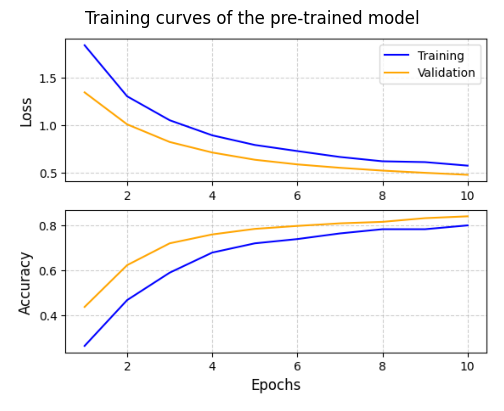

In [15]:
if training_phase == 'Yes':
  plot_evolution(classifier_accuracy)
else:
  training_curves_1, training_curves_2, model, model_FT = get_github_files()
  plt.imshow(training_curves_1), plt.title("Training curves of the pre-trained model"), plt.axis("off")

###### **3.4. Evaluation**

In [16]:
loss_test, accuracy_test = model.evaluate(test_dataset, verbose=0)
print("Test loss function value %0.1f and test accuracy value %0.1f %%" %(loss_test, 100*accuracy_test))

Test loss function value 0.4 and test accuracy value 85.9 %


The accuracy of the test set obtained is significantly higher to that obtained in the previous model (see 04_convolution_CNN.ipynb). This increase of 10% is notably due to the complexity of the extraction model used as input to the classification model.

Extending training to other epochs would not bring a significant gain in accuracy to the model, since the training and validation curves start to stagnate at the 10th epoch.

---


### **4. Fine tuning**

###### **4.1. "Defrosted" model extractor**

In order to increase model's performances, some layers of the model MobileNet V2 are unfrozen. Parameters will be updated during training. MobileNet V2 has been trained on generic flower images and it would be preferable to train it on specific flower images (dataset flowers).

[[3]](https://www.tensorflow.org/tutorials/images/transfer_learning?hl=fr) recommends unfreezing only the first layers of the MobileNet model, and keeping the deeper layers of high-feature extractions frozen. The feature extraction model MobileNet V2 has 154 layers, 2/3 of which are unfrozen.

In [17]:
extractor_model.trainable = True

In [18]:
fine_tune_at = 100
for layer in extractor_model.layers[:fine_tune_at]:
  layer.trainable = False

###### **4.2. Training phase**

To prevent the model from overfitting rapidly, the learning rate must be smaller than the previous training phase.

In [19]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [20]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

if training_phase == "Yes":
  classifier_accuracy_FT = train_model(model, train_dataset, validation_dataset, epochs=fine_tune_epochs)
  model.save('05_transfert_learning_FT.keras')
  print("Accuracy max %0.1f %% reached at the epoch %d" %(100*max(classifier_accuracy_FT[3]), argmax(classifier_accuracy_FT[3])+1))

###### **4.3. Evaluation**

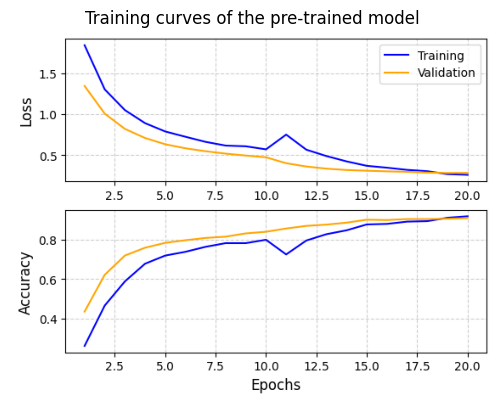

In [21]:
if training_phase == 'Yes':
  plot_evolution(concat([classifier_accuracy, classifier_accuracy_FT], 1))
else:
  model = model_FT
  plt.imshow(training_curves_2), plt.title("Training curves of the pre-trained model"), plt.axis("off")

In [22]:
loss_test, accuracy_test = model.evaluate(test_dataset, verbose=0)
print("Test loss function value %0.1f and test accuracy value %0.1f %%" %(loss_test, 100*accuracy_test))

Test loss function value 0.2 and test accuracy value 93.0 %


**The accuracy achieved on the test set (>92%) is better with a pre-trained model used to extract complex features than that obtained by a simple sequential model composed of convolution layers (71%) (see: *04_convolution_CNN.ipynb*).**

---


### **5. Predictions**

In [23]:
tulip, rose, daisy, sunflowers, bouquet, bouquet_2 = get_github_photo()

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 556, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 556 (delta 149), reused 94 (delta 94), pack-reused 368 (from 1)
Receiving objects: 100% (556/556), 134.24 MiB | 19.29 MiB/s, done.
Resolving deltas: 100% (276/276), done.


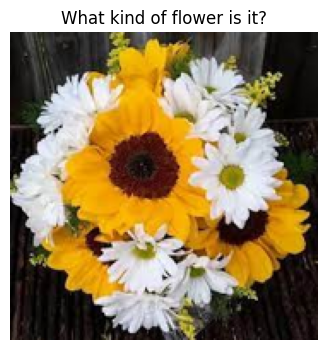

In [24]:
img = bouquet
img = Image.fromarray(array(img))
resized_img = img.resize((img_height, img_width))
plt.figure(figsize=(4, 4))
plt.imshow(resized_img), plt.title("What kind of flower is it?"), plt.axis("off")
plt.show()

In [25]:
resized_img_array = expand_dims(array(resized_img), 0)
predictions = model.predict(resized_img_array)
score = nn.softmax(predictions[0])

df = DataFrame(data={'class_names': class_names, 'score': 100*score.numpy()})
print(df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
  class_names      score
0       daisy   0.564565
1   dandelion   0.011895
2       roses   0.017675
3  sunflowers  99.393448
4      tulips   0.012417


---


### **6. References**


| | | | | |
|------|------|------|------|------|
| Index | Title | Author(s) | Type | Comments |
|[[1]](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition) | Flowers Recognition | Alexander Mamaev | dataset | - |
|[[2]](https://keras.io/api/applications/mobilenet/) | MobileNet, MobileNetV2, and MobileNetV3 | Keras | Tutoriels | - |
|[[3]](https://www.tensorflow.org/tutorials/images/transfer_learning?hl=fr) | Transfer learning and fine-tuning  | TensorFlow | Tutoriels | - |
|[[4]](https://arxiv.org/abs/1704.04861) | MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications | Andrew G. Howard and al. | paper | - |